In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import json
import gzip

In [23]:
#import the databases needed for the study
path= './data/'
#df=pd.read_csv(path + 'Country_data.csv')
df_topics_linked = pd.read_csv(path + 'topics_linked.csv.xz')
df_interventions = pd.read_csv(path + 'interventions.csv')
df_democracy=pd.read_csv(path + 'democracy.csv')


#Load the (gzipped) json file of the wikidata database
with gzip.open(path + 'aggregated_timeseries.json.gz', "rb") as f:
    json_timeseries = json.loads(f.read().decode("ascii"))

In [24]:
#Setting the Years after 1960 as indexes in order to plot the evolution of the democracy index 
df_democracy_plot=df_democracy[df_democracy['Year']>=1960]
df_democracy_plot.set_index('Year',inplace=True)

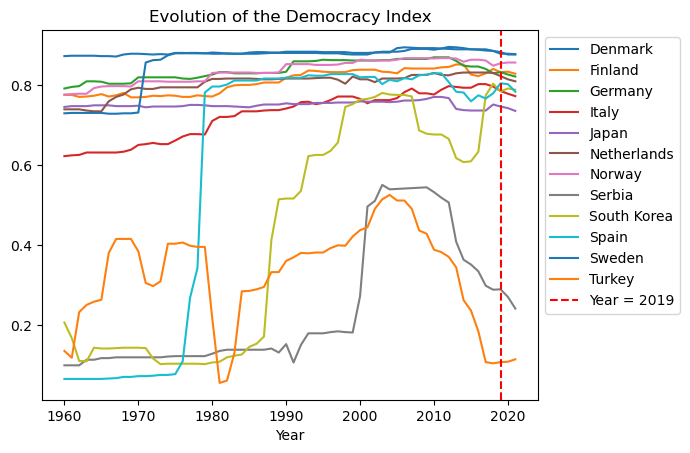

In [25]:
#Grouping the countries and ploting their evolution.
df_democracy_plot[(df_democracy_plot['Entity'].isin(['Denmark','Finland','Germany','Italy','Japan','Netherlands','Norway','Serbia','South Korea', 'Spain', 'Sweden', 'Turkey']))].groupby('Entity')['libdem_vdem_owid'].plot(x='Year',y='libdem_vdem_owid',legend=True)

#Drawing the limit of the year 2019 since this is the year where we will consider the democracy score for the countries for our study
plt.axvline(x = 2019, color = 'r',ls='--', label = 'Year = 2019')
plt.title('Evolution of the Democracy Index')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
#resent the index from the Year to before the plotting...
df_democracy_plot.reset_index(inplace=True)

In [26]:
#import the geopandas database in order to plot the maps
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

#merge with the democracy index database in order to associate to each of our wanted country a democracy score.
countries = countries.merge(df_democracy[df_democracy["Year"]==2019][['Entity','libdem_vdem_owid']],left_on='name',right_on='Entity',how='left')
countries.drop('Entity', inplace=True, axis=1)

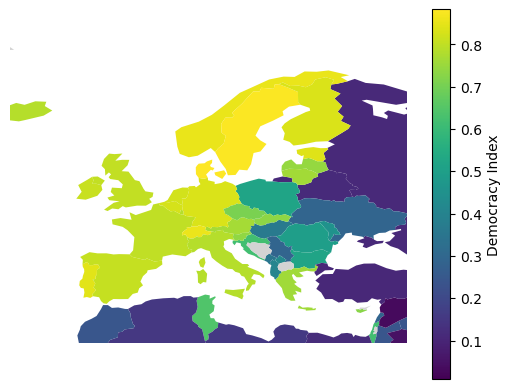

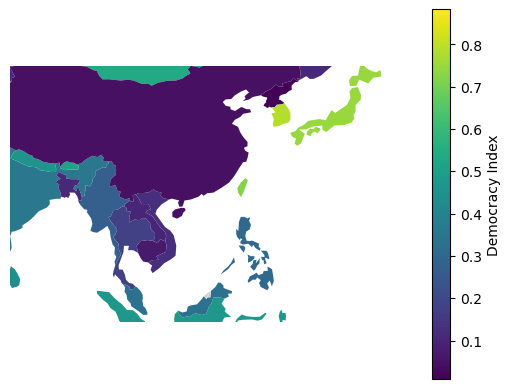

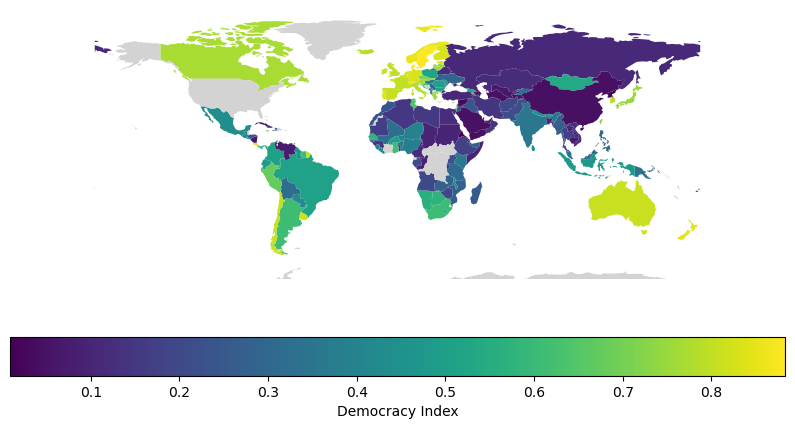

In [27]:
#Plotting and drawing the maps with the democracy scores.

ax1=countries.plot(column='libdem_vdem_owid', legend=True,legend_kwds={'label': "Democracy Index",
                        'orientation': "vertical"}, missing_kwds={'color': 'lightgrey'})
ax2=countries.plot(column='libdem_vdem_owid', legend=True,legend_kwds={'label': "Democracy Index",
                        'orientation': "vertical"}, missing_kwds={'color': 'lightgrey'})
ax3=countries.plot(column='libdem_vdem_owid', legend=True,legend_kwds={'label': "Democracy Index",
                        'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'},figsize=(10, 5))
ax1.set_xlim(-20,40)
ax1.set_ylim(30,75)
ax1.set_axis_off()

ax2.set_xlim(80,150)
ax2.set_ylim(0,45)
ax2.set_axis_off()

ax3.set_ylim(-70,90)
ax3.set_axis_off()

plt.show()



In [28]:
# a list of the names of the wikipedia versions.
wiki_versions =['sv','de','it','sr','no','ko','da','ja','nl','fi','ca','tr']


#Here we want to find the dat eof the beginning of the lockdown and insert it in the dictionnary in order to later plot it
lockdown_start_dic={'sv':0,'de':0,'it':0,'sr':0,'no':0,'ko':0,'da':0,'ja':0,'nl':0,'fi':0,'ca':0,'tr':0}


def find_lockdown_start(version):
    # Let's put in the list time the list of the days of the considered period
    time = list(json_timeseries[version]['sum'].keys())
    # We just remove the hours
    time = [t[:10] for t in time]

    # Thanks to the dataframe df_interventions we can get the dates of the lockdown in the associated country
    lockdown_start = df_interventions.loc[df_interventions['lang'] == version]['Mobility'].to_list()
    # We compute the index of these dates in the list of the days
    start_index = time.index(lockdown_start[0])-365
    return lockdown_start[0],start_index

#compute the start lockdown indexes and store them in the dictionnary    
for version in wiki_versions:
    lockdown_start_dic[version]=find_lockdown_start(version)[1]
    
print(lockdown_start_dic)

{'sv': 435, 'de': 440, 'it': 435, 'sr': 440, 'no': 435, 'ko': 420, 'da': 435, 'ja': 455, 'nl': 440, 'fi': 440, 'ca': 440, 'tr': 440}


In [29]:
#This is a function that gives us the x and y axis corresponding to the time stamps starting the year 2019 for the x-axis,
# and the number of searches per days for the y-axis

def wiki_searches_axis(version):
    V=json_timeseries[version]['sum']
    myList = V.items()
    myList = sorted(myList) 
    x, y = zip(*myList) 
    return np.array(x[365:]),np.array(y[365:])

# This function calculates the rolling average of an array x over a window of width w
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


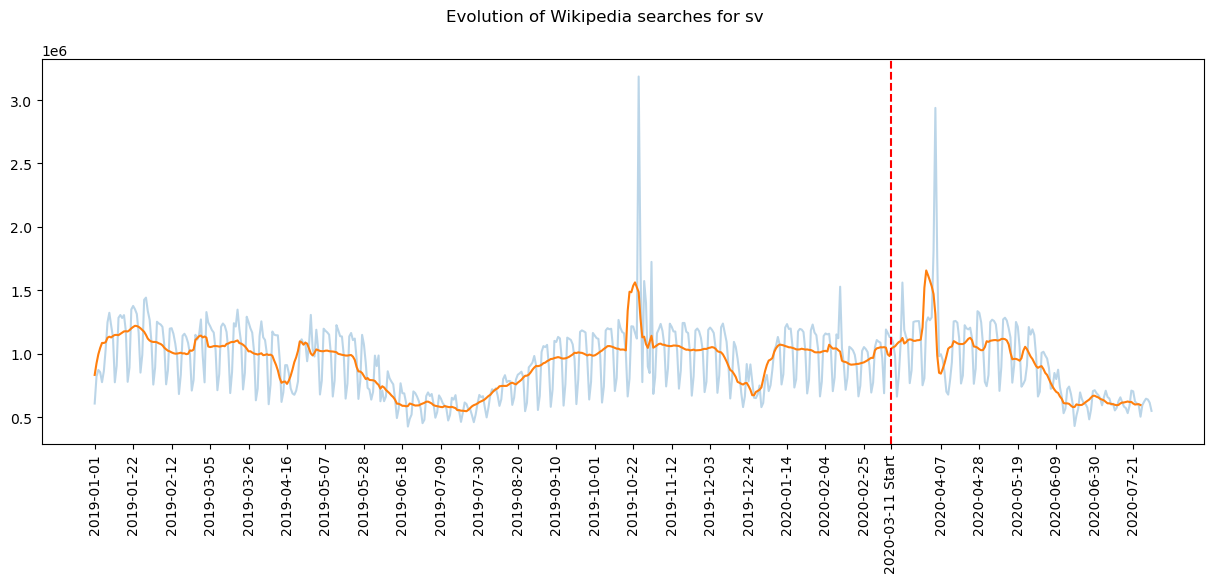

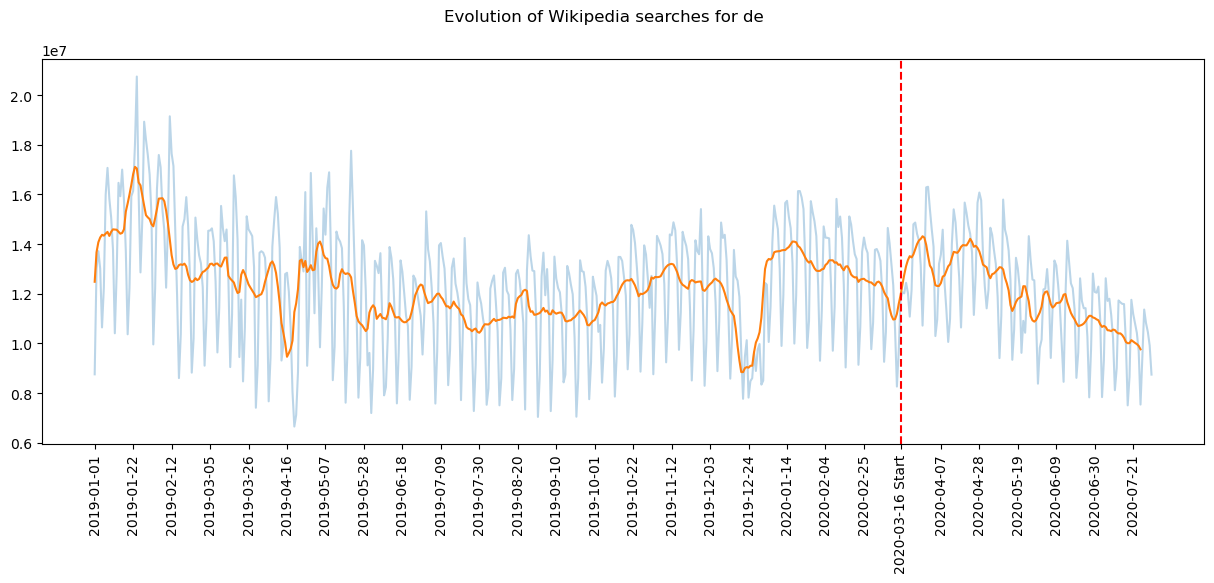

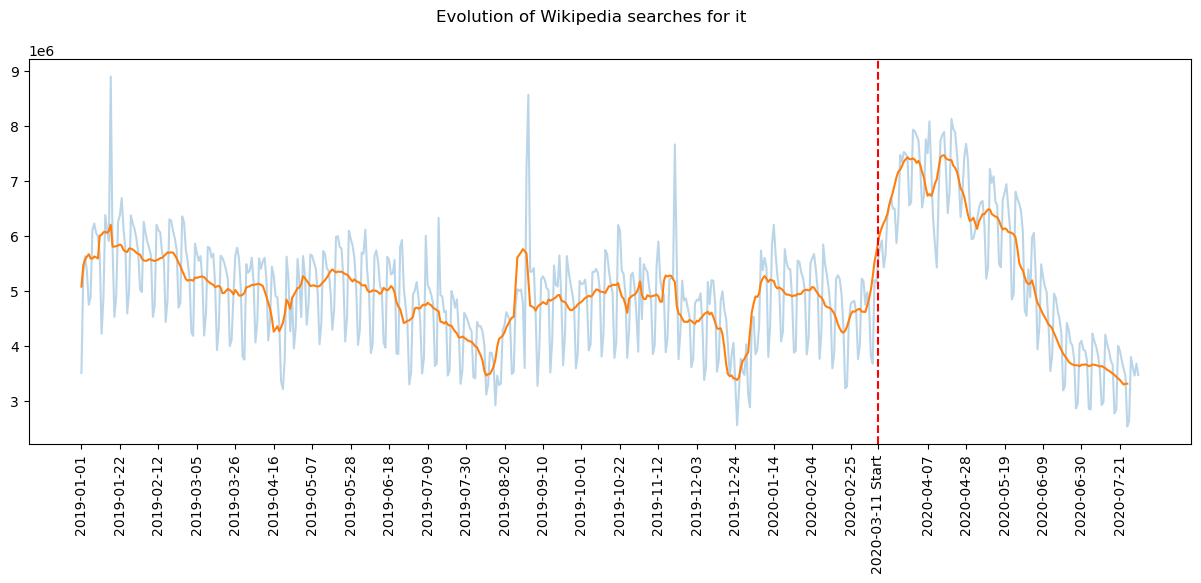

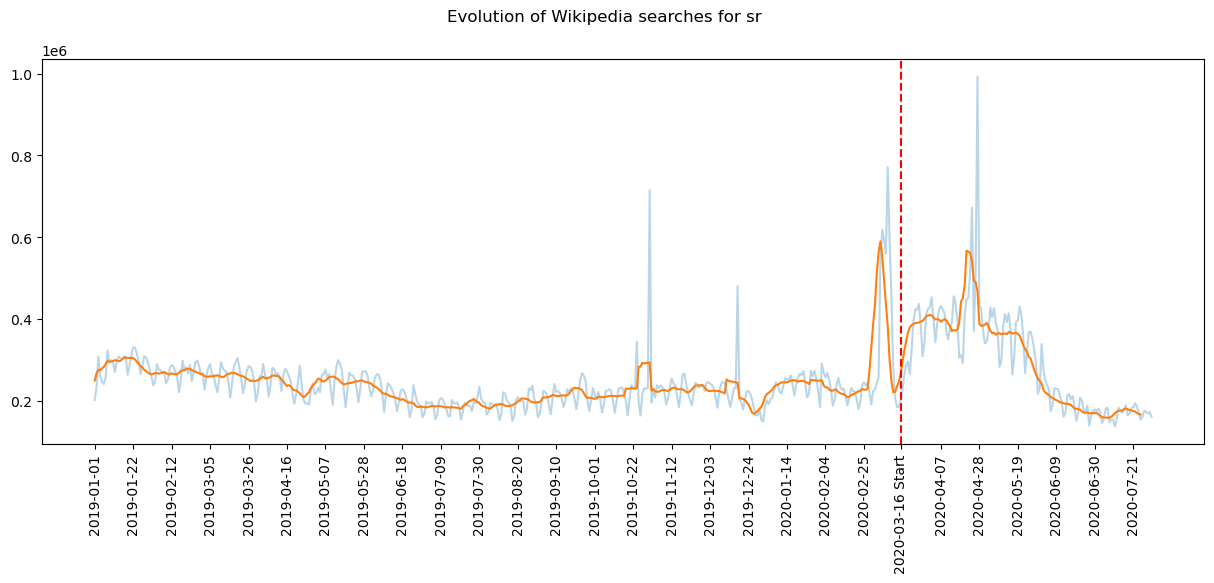

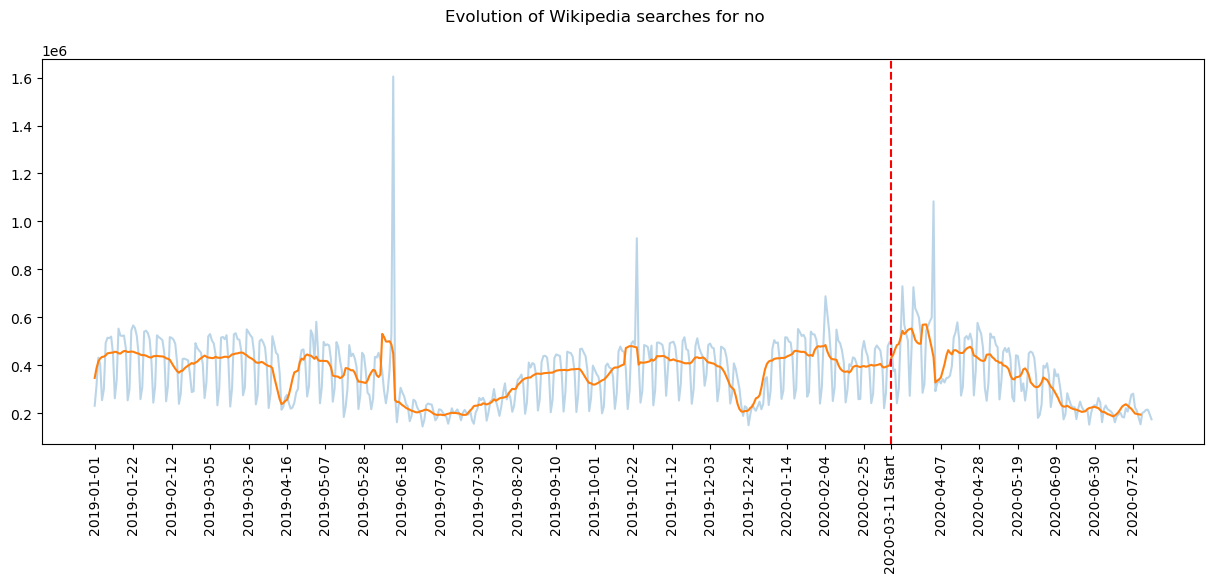

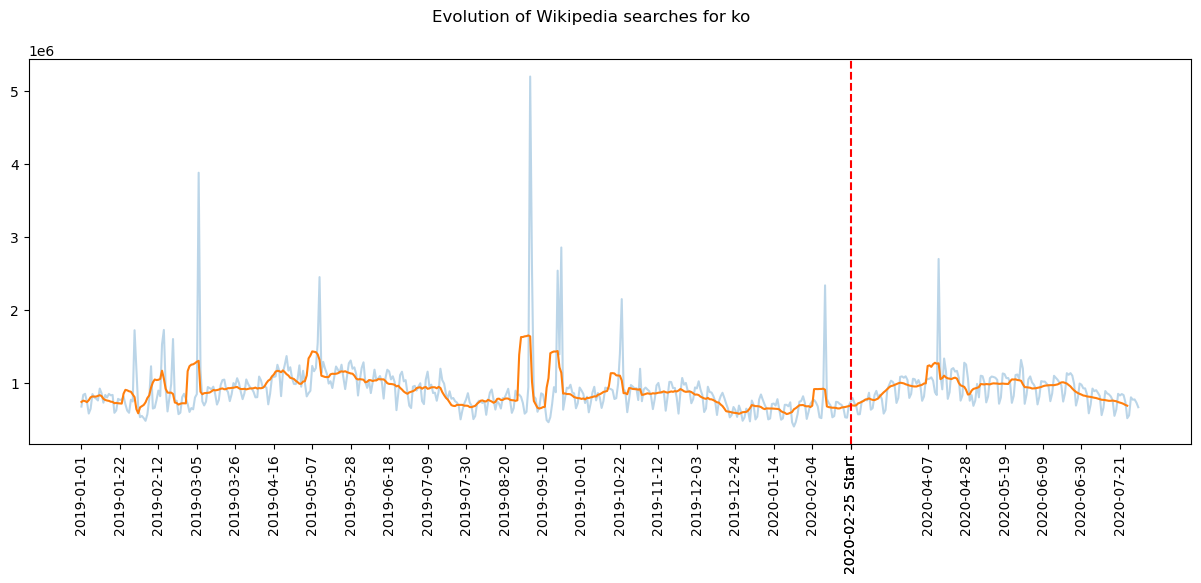

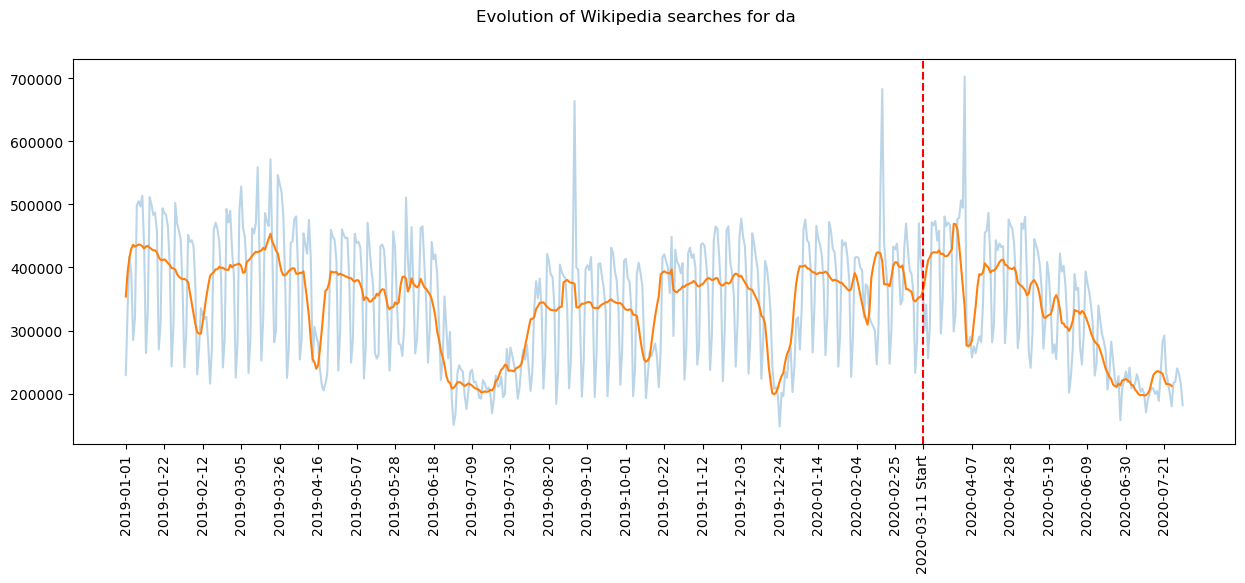

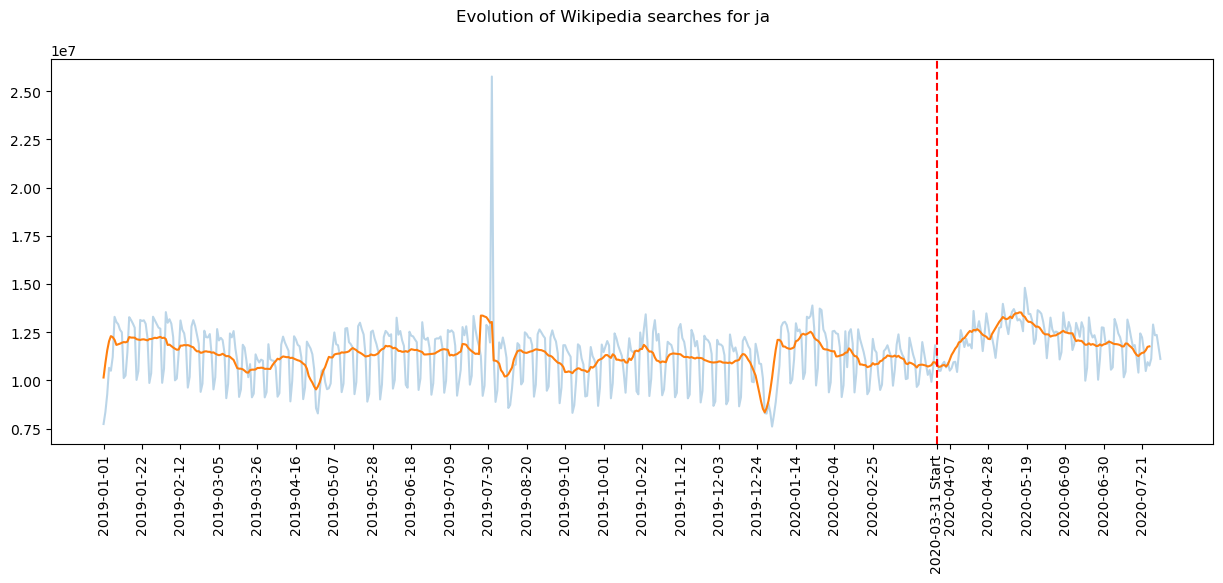

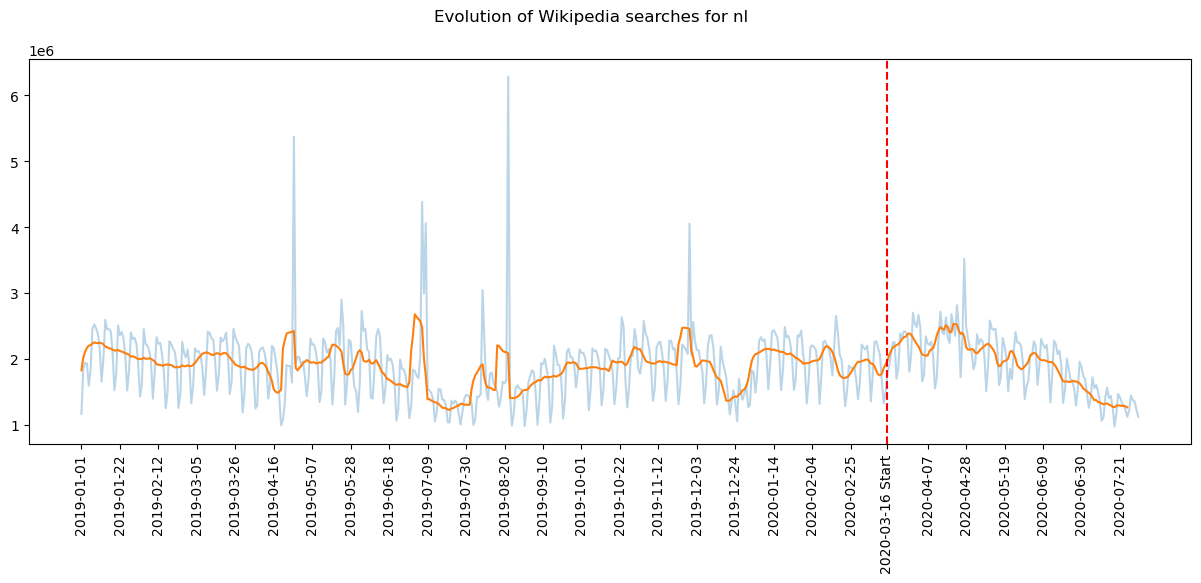

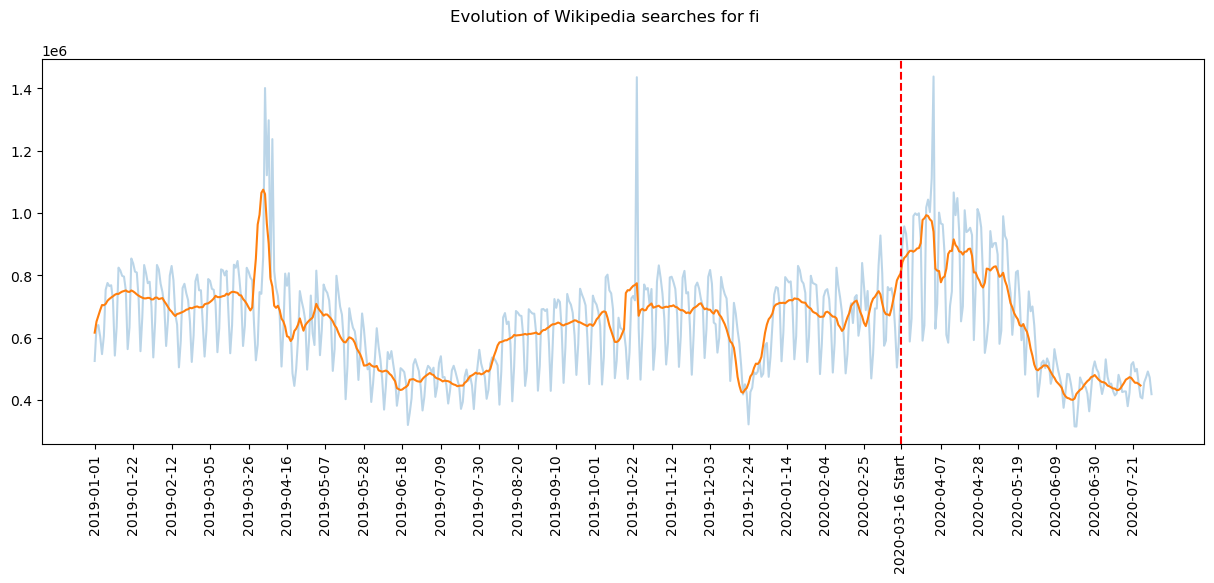

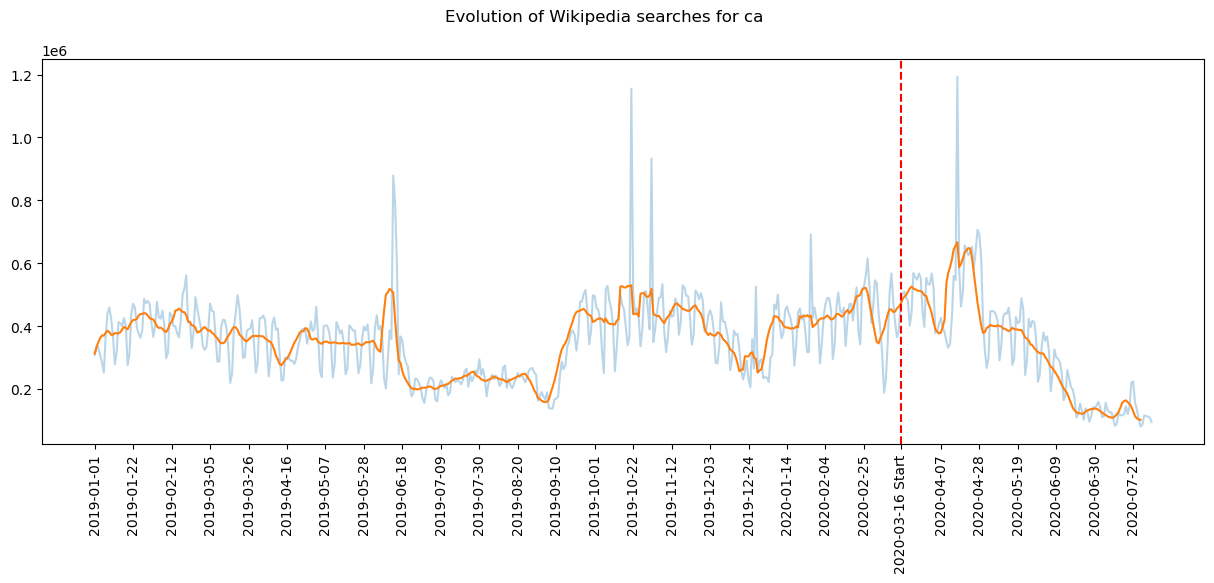

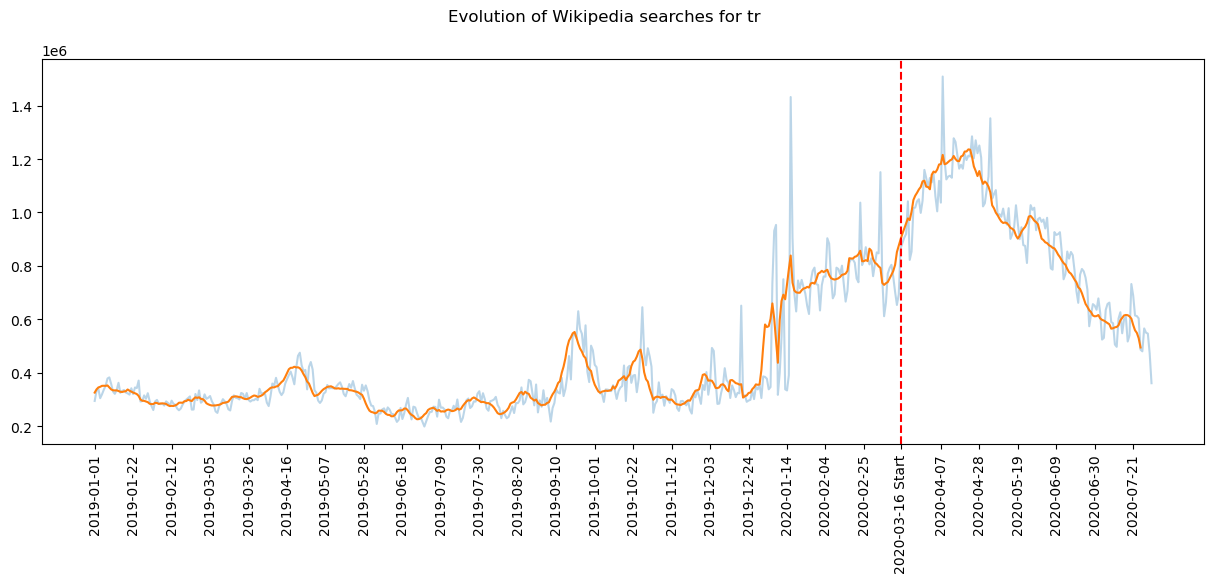

In [30]:
def plot_wiki_searches(version):

    # Let's put in the list time the list of the days of the considered period
    time = list(json_timeseries[version]['sum'].keys())
    # We just remove the hours
    time = [t[:10] for t in time]

    # For the purpose of plotting our results we create a list of days with only 1 day in 21 and we also create a list of index for these days
    time_reduced = [time[21*i+365] for i in range(int(len(time[365:])/21)+1)]
    time_pos = [21*i for i in range(int(len(time[365:])/21)+1)]


    lockdown_start,start_index = find_lockdown_start(version)
    # We compute the index of these dates in the list of the days
    start_index = time.index(lockdown_start)-365
    time_pos.append(start_index)
    time_reduced.append(lockdown_start+' Start')

    # We also remove two points which are too close from the start/end of the lockdown to have a nice plot
    time_pos.pop(time_reduced.index('2020-03-17'))
    time_reduced.pop(time_reduced.index('2020-03-17'))
    
    #finding our axis
    x,y=wiki_searches_axis(version)

    fig, ax1 = plt.subplots(figsize=(15,5))
    fig.suptitle("Evolution of Wikipedia searches for {version}".format(version=version))

    #compute the rolling mean
    rolling_mean=np.array(moving_average(y,7))
    
    #Plotting everything
    ax1.plot(x, y, alpha=0.3)
    ax1.plot(x[:len(x)-6],rolling_mean)
    ax1.axvline(x = lockdown_start_dic[version], color = 'r',ls='--', label = 'Year = 2020')
    
    
    ax1.set_xticks(time_pos,time_reduced,fontsize=10)
    ax1.tick_params('x',labelrotation=90)
    plt.show()

for version in wiki_versions:
    plot_wiki_searches(version)



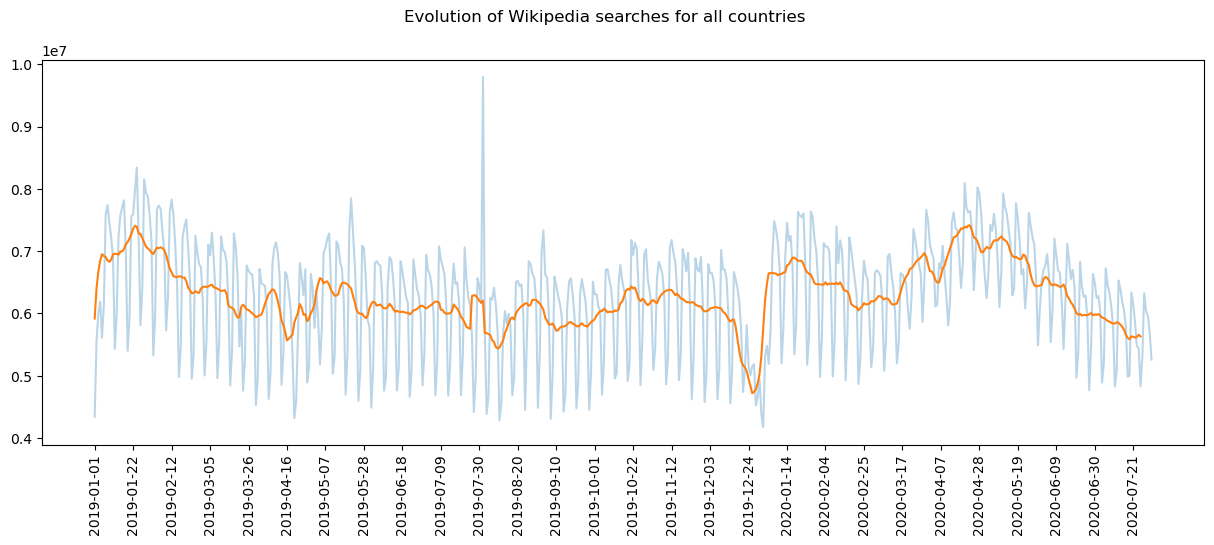

In [31]:

#dictionnary with the population of each country
country_population={'sv':10.28e6,'de':83.09e6,'it':59.73e6,'sr':6.945e6,'no':5.348e6,'ko':51.76e6,'da':5.814e6,'ja':126.6e6,'nl':17.34e6,'fi':5.522e6,'ca':7.566e6,'tr':83.43e6}

#plot the mean on the wikipedia searches for the countries, weighted according to the country's population.
def plot_sum_wiki():
    sum_searches=np.zeros(578)
    
    # Let's put in the list time the list of the days of the considered period
    time = list(json_timeseries['it']['sum'].keys())
    # We just remove the hours
    time = [t[:10] for t in time]

    # For the purpose of plotting our results we create a list of days with only 1 day in 21 and we also create a list of index for these days
    time_reduced = [time[21*i+365] for i in range(int(len(time[365:])/21)+1)]
    time_pos = [21*i for i in range(int(len(time[365:])/21)+1)]
    
    #compute the mean value of the searches
    for K in wiki_versions:
        x,y=wiki_searches_axis(K)
        sum_searches=np.add(sum_searches,country_population[K]*y)
    sum_searches=sum_searches/sum(country_population.values())

    #compute the rolling mean
    rolling_mean=np.array(moving_average(sum_searches,7))
    

    # plotting
    fig, ax1 = plt.subplots(figsize=(15,5))
    fig.suptitle("Evolution of Wikipedia searches for all countries")
    ax1.plot(x, sum_searches, alpha=0.3)
    ax1.plot(x[:len(x)-6],rolling_mean)
    
    #setting the ticks
    ax1.set_xticks(time_pos,time_reduced,fontsize=10)
    ax1.tick_params('x',labelrotation=90)
    plt.show()

plot_sum_wiki()
